# Evaluation

In [1]:
# ===============================
# 🧱 Standard Libraries
# ===============================
import os
import json
from collections import Counter
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# ===============================
# 🔢 Numerical & Audio Processing
# ===============================
import numpy as np
import torch
import librosa
import pandas as pd

# ===============================
# 📊 Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 📦 Dataset Loading & Evaluation
# ===============================
from datasets import load_dataset, Audio
import evaluate
import jiwer
from tqdm import tqdm

# ===============================
# 🤗 HuggingFace Transformers
# ===============================
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM
)

# ===============================
# 📈 NLP Evaluation Metrics
# ===============================
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# ===============================
# ☁️ Hugging Face Hub Utilities
# ===============================
from huggingface_hub import (
    HfApi,
    HfFolder,
    whoami,
    notebook_login,
    create_repo
)

# ===============================
# 🚀 Deployment
# ===============================
import gradio as gr


### Bar Chart

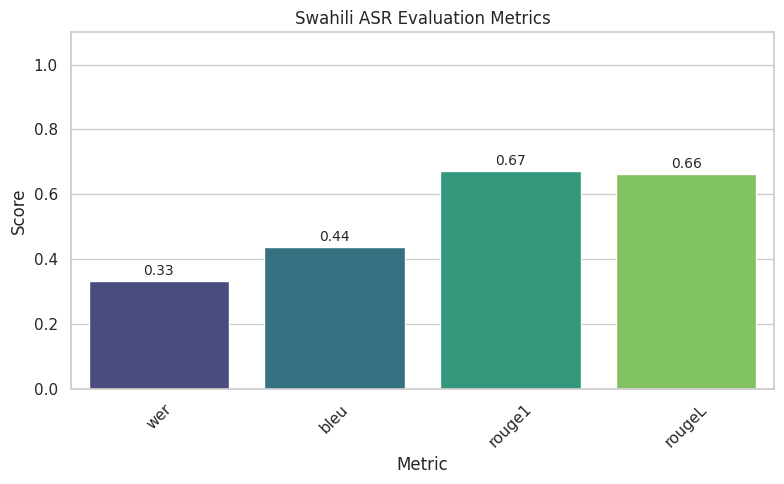

In [2]:
# Load saved metrics
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)

# Filter numerical metrics only
plot_metrics = {k: v for k, v in metrics.items() if isinstance(v, (int, float))}

# Convert to DataFrame
df = pd.DataFrame({
    "Metric": list(plot_metrics.keys()),
    "Score": list(plot_metrics.values())
})

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x="Metric", y="Score", hue="Metric", palette="viridis", legend=False)

# Add score labels on top of each bar
for i, row in df.iterrows():
    ax.text(i, row["Score"] + 0.01, f"{row['Score']:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Swahili ASR Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Radar Chart

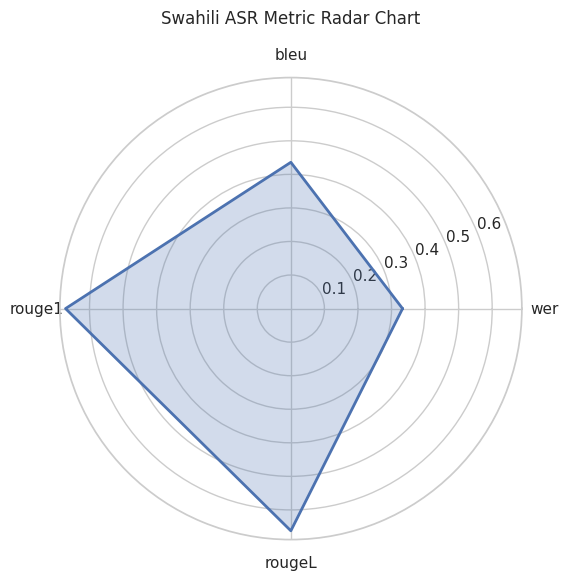

In [3]:
# Filter numerical metrics
labels = list(plot_metrics.keys())
scores = list(plot_metrics.values())

# Radar prep
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
scores += scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, scores, linewidth=2, linestyle='solid')
ax.fill(angles, scores, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Swahili ASR Metric Radar Chart", y=1.1)
plt.show()


## Sentiment Pie Chart

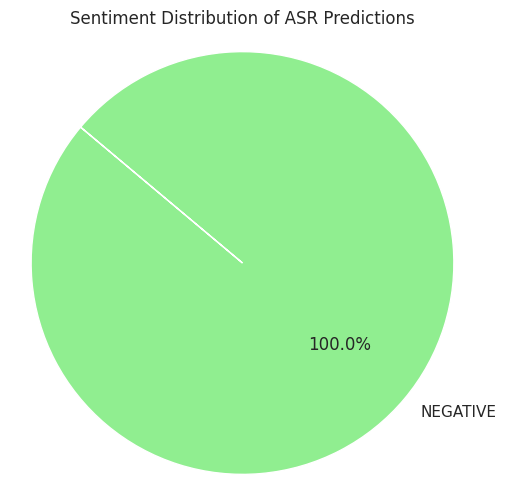

In [4]:
# Load sentiment data
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)
sentiments = metrics["sentiment_sample"]  # Correct key

# Count each label
sentiment_counts = Counter([s["label"] for s in sentiments])

# Plot
labels = sentiment_counts.keys()
sizes = sentiment_counts.values()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["lightgreen", "salmon"])
plt.title("Sentiment Distribution of ASR Predictions")
plt.axis('equal')  # Equal aspect ratio ensures pie is round
plt.show()


## Sentiment Analysis Bar Graph

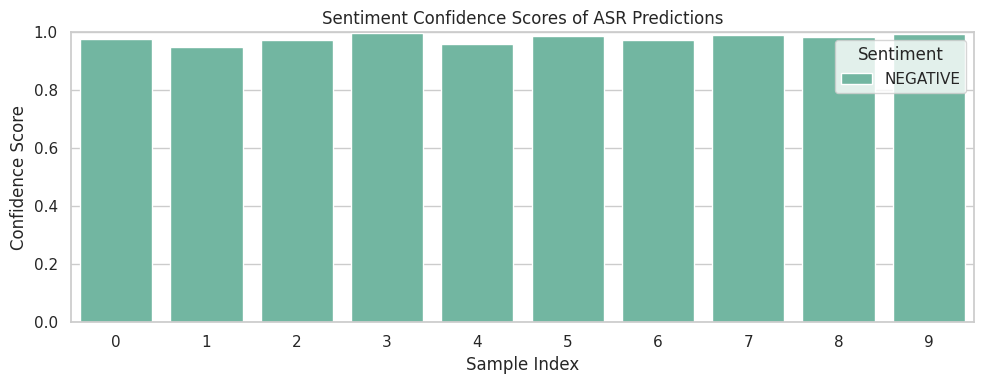

In [5]:
# Load sentiment data
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)

# Access the sentiment sample
sentiments = metrics["sentiment_sample"]

# Extract labels and confidence scores
labels = [s["label"] for s in sentiments]
scores = [s["score"] for s in sentiments]

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(range(len(sentiments))), y=scores, hue=labels, dodge=False, palette="Set2")
plt.ylim(0, 1)
plt.xlabel("Sample Index")
plt.ylabel("Confidence Score")
plt.title("Sentiment Confidence Scores of ASR Predictions")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [1]:
# Load model directly
from transformers import AutoProcessor, AutoModelForCTC
import gradio as gr
import torch
import numpy as np

# Load ASR model and processor
processor = AutoProcessor.from_pretrained("RareElf/swahili-wav2vec2-asr")
model = AutoModelForCTC.from_pretrained("RareElf/swahili-wav2vec2-asr")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define transcription function
def transcribe_audio(audio):
    if audio is None:
        return "No audio provided"
    
    try:
        # Process audio - Gradio returns a tuple of (sample_rate, audio_array)
        sample_rate = audio[0]
        audio_array = audio[1]
        
        # Convert to float32 to match model's expected type
        audio_array = np.array(audio_array).astype(np.float32)
        
        # Resample if needed
        if sample_rate != 16000:
            import librosa
            audio_array = librosa.resample(y=audio_array, orig_sr=sample_rate, target_sr=16000)
        
        # Get model prediction
        inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(inputs.input_values.to(torch.float32)).logits
        
        # Decode prediction
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]
        
        return transcription
    except Exception as e:
        return f"Error processing audio: {str(e)}"

# Create Gradio interface
demo = gr.Interface(
    fn=transcribe_audio,
    inputs=[
        gr.Audio(sources=["microphone", "upload"], type="numpy")
    ],
    outputs=[
        gr.Textbox(label="Swahili Transcription")
    ],
    title="Swahili Speech Recognition",
    description="Transcribe Swahili speech using the RareElf/swahili-wav2vec2-asr model. You can record audio or upload an audio file."
)

# Launch the app
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
